# Gibbs Sampling
#### Using Beta-binomial distribution as a learning example
----
The ideas and examples are from [Explaning the Gibbs Sampler](http://biostat.jhsph.edu/~mmccall/articles/casella_1992.pdf) which uses the example of simulating the beta-binomial distribution using the conditional distributions where the beta distribution is the [conjugate distribution](https://en.wikipedia.org/wiki/Conjugate_prior) of the binomial distribution.

### Introduction
Write this later...

### Let's Start!
For a given $n, \theta$, we can write the binomial distribution as 
\begin{align*}
X \mid n, \theta &\sim Bin(n,\theta), \text{ with}\\
f(k\mid \theta) &= \mathbb{P}(X = k\mid n, \theta) = \binom{n}{k} \theta^{k} (1-\theta)^{n-k}
\end{align*}
and the probability above is known as the *likelihood*, the probability of the evidence $X=k$ given the parameters $\theta$.

For a Beta distribution with given $\alpha, \beta$,
\begin{align*}
\Theta \mid \alpha, \beta &\sim Beta(\alpha,\beta)\\
f(\theta) &= \frac{1}{B(\alpha, \beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}
\end{align*}
and the probability is known as the *prior probability*, which tells us how the parameters are distributed. The Beta-binomial distribution is a binomial distribution such that the probability of success at each trial follows a beta distribution, i.e. $\Theta_i = \theta$. The *posterior probability*, which is the probability of the parameter $\theta$ given the evidence $X = k$ is written as 
\begin{align*}
f(\theta \mid k)&=\frac{f(k\mid\theta)\cdot f(\theta)}{\int_{0}^{1} f(k\mid\theta)\cdot f(\theta)\, d\theta}\\
&=\frac{\binom{n}{k} \theta^{k} (1-\theta)^{n-k}\frac{1}{B(\alpha, \beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}}{\int_{0}^{1}\binom{n}{k} \theta^{k} (1-\theta)^{n-k}\frac{1}{B(\alpha, \beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}\,d\theta}\\
&=\frac{ \theta^{k+\alpha-1} (1-\theta)^{n-k+\beta-1}}{\int_{0}^{1} \theta^{k+\alpha-1} (1-\theta)^{n-k+\beta-1}\,d\theta}\\
&=\frac{ \theta^{k+\alpha-1} (1-\theta)^{n-k+\beta-1}}{B(k+\alpha,n-k+\beta)}\\
\end{align*}
The denominator of the above expression is the marginal distribution of $X$, 
\begin{align*}
f(k;n,\alpha,\beta) &= \int_{0}^{1}\binom{n}{k} \theta^{k} (1-\theta)^{n-k}\frac{1}{B(\alpha, \beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}\,d\theta\\ 
&=\binom{n}{k}\frac{B(k+\alpha,n-k+\beta)}{B(\alpha, \beta)}
\end{align*}
which is shown to be the *beta-binomial distribution*.

In [1]:
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

% matplotlib inline

We will be using the following parameters/hyperparameters for the beta, binomal and beta-binomial distribution.

In [2]:
n = 20
alpha = 20
beta = 40

### Beta-binomial distribution
Below we show a plot of the beta-binomial distribution that we are going to compare with our Gibbs sampling later.

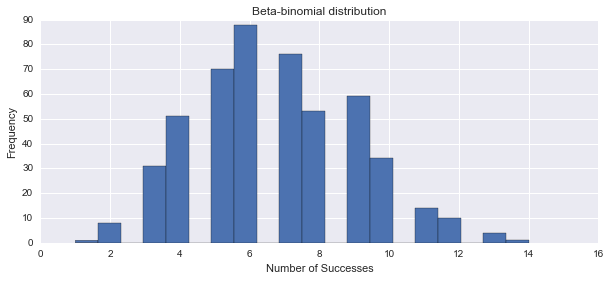

In [3]:
sample = []
for i in range(500):
    theta = np.random.beta(alpha, beta)
    sample.append(np.random.binomial(n, theta))

fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(sample, bins = n)  
plt.title('Beta-binomial distribution')
plt.xlabel('Number of Successes')
plt.ylabel('Frequency')

### How to do Gibbs Sampling
The idea of the Gibbs sampler is to generate a sample from $f(x)$ from the conditional distributions $f(x\mid y)$ and $f(y\mid x)$ which are distributions often known.
1. Set initial value $(k^{(0)}, \theta^{(0)})$.
2. For $i = 1, 2, \ldots, N$
    - Sample $k^{(i)}\sim f(k\mid \theta^{(i-1)})$
    - Sample $\theta^{(i)}\sim f(\theta\mid k^{(i)})$
3. The process produces samples of $(k^{(i)}, \theta^{(i)})$
4. Approximate $f(x)$ with the values of $x^{(i)}$

In [4]:
def binom_sample(n, theta):
    """
    Returns a sample from a binomal distribution with n independent trials and success rate theta.
    Inputs:
    - n: (int) number of trials.
    - theta: a probability denoting the success rate.
    """
    return np.random.binomial(n, theta)

In [5]:
def beta_sample(k, alpha, beta, n):
    """
    Returns the a sample from the beta distribution with parameters k + alpha and n - k + beta.
    Inputs:
    - k: (int) taken from the sample obtain from the binomial distribution.
    - alpha, beta: parameters for the beta distribution. 
    - n: (int) number of trials for the binomial distribution.
    """
    return np.random.beta(k + alpha, n - k + beta)

In [6]:
def gibbs_seq(l, theta, alpha, beta, n):
    """
    Returns a Gibbs sequence of length l with parameters k, theta, alpha, beta.
    Inputs:
    - l: (int) length of sequence.
    - alpha, beta: parameters for the beta distribution. 
    - n: (int) number of trials for the binomial distribution.
    - theta: a randomly initiated initial value between [0,1]
    """ 
    seq = []
    for i in range(n):
        x = binom_sample(n, theta)
        seq.append(x)
        theta = beta_sample(x, alpha, beta, n)
    return seq       

In [7]:
def finalvalue_gibbs_seq(m, l, theta, alpha, beta, n):
    """
    Creates m gibbs sequences of length l and takes the final observation as a sample point.
    Inputs:
    - m: (int) number of gibbs sequences to be constructed.
    - l: (int) length of sequence.
    - alpha, beta: parameters for the beta distribution. 
    - n: (int) number of trials for the binomial distribution.
    - theta: a randomly initiated initial value between [0,1]
    """    
    seq = []
    for i in range(m):
        s = gibbs_seq(l, theta, alpha, beta, n)
        seq.append(s[-1])
    return seq    

To begin the Gibbs sampling, we need an initial value of $\theta$ to be specified, which I choose to draw from a uniform distribution $\mathcal{U}(0,1)$.

In [8]:
theta = np.random.uniform(0,1,1)
seq = finalvalue_gibbs_seq(500, 100, theta, alpha, beta, n)

If you like, we can do another 500 samples from the beta-binomial distribution.

In [9]:
sample = []
for i in range(500):
    theta = np.random.beta(alpha, beta)
    sample.append(np.random.binomial(n, theta))

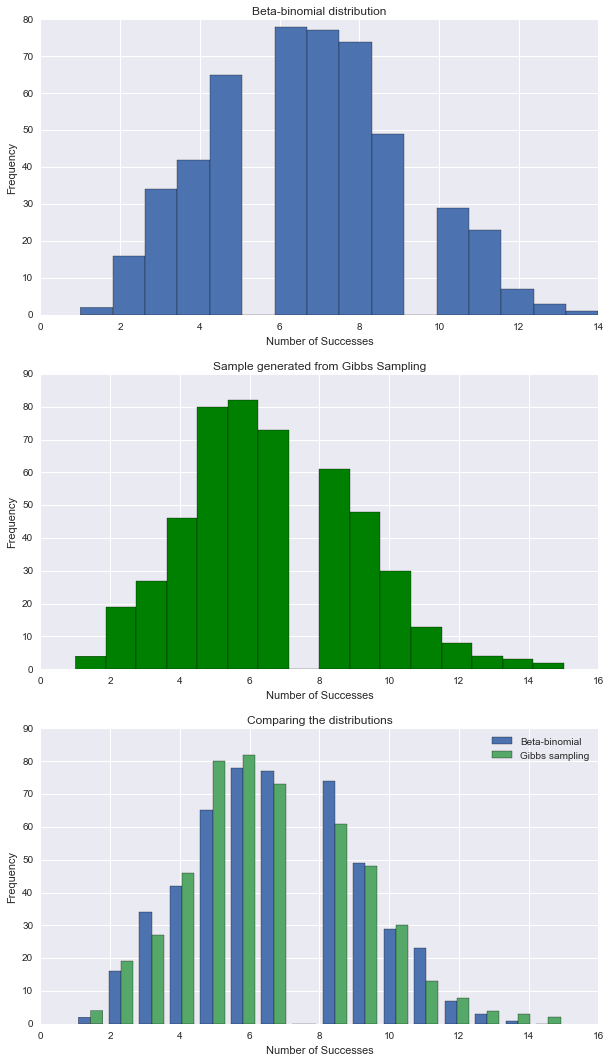

In [10]:
fig, ax = plt.subplots(3, figsize=(10, 18))
combined = [sample, seq]
ax[0].hist(sample, bins = 16)
ax[1].hist(seq, bins = 16, color = 'green')
ax[2].hist(combined, bins = 16, label = ['Beta-binomial', 'Gibbs sampling'])

ax[0].set_title('Beta-binomial distribution')
ax[1].set_title('Sample generated from Gibbs Sampling')
ax[2].set_title('Comparing the distributions')

ax[2].legend(loc = 'best')

for i in ax:
    i.set_xlabel('Number of Successes')
    i.set_ylabel('Frequency')

### We can combine everything and run it in a single cell

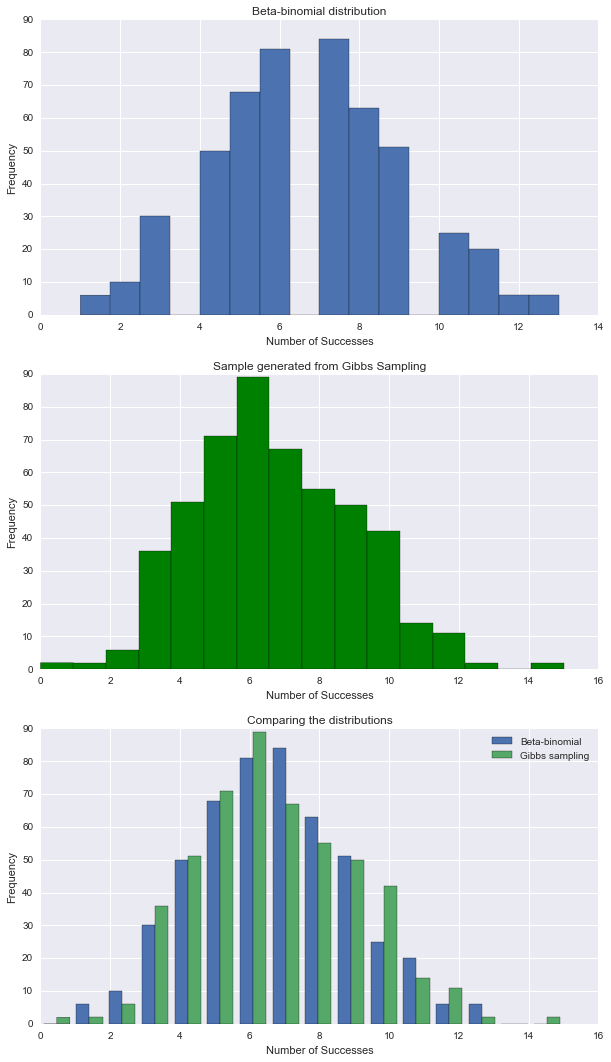

In [11]:
theta = np.random.uniform(0,1,1)
seq = finalvalue_gibbs_seq(500, 10000, theta, alpha, beta, n)
sample = []
for i in range(500):
    theta = np.random.beta(alpha, beta)
    sample.append(np.random.binomial(n, theta))
fig, ax = plt.subplots(3, figsize=(10, 18))
combined = [sample, seq]
ax[0].hist(sample, bins = 16)
ax[1].hist(seq, bins = 16, color = 'green')
ax[2].hist(combined, bins = 16, label = ['Beta-binomial', 'Gibbs sampling'])

ax[0].set_title('Beta-binomial distribution')
ax[1].set_title('Sample generated from Gibbs Sampling')
ax[2].set_title('Comparing the distributions')

ax[2].legend(loc = 'best')
for i in ax:
    i.set_xlabel('Number of Successes')
    i.set_ylabel('Frequency')    